## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.regularizers import l1, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-2, l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if l1_ratio != 0 and l2_ratio == 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(l1_ratio))(input_layer)
            elif l1_ratio != 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
            elif l1_ratio == 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(l2_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1))(input_layer)
        else:
            if l1_ratio != 0 and l2_ratio == 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(l1_ratio))(x)
            elif l1_ratio != 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
            elif l1_ratio == 0 and l2_ratio != 0:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(l2_ratio))(x)
            else:
                x = keras.layers.Dense(units=n_units,
                                       activation="relu",
                                       name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-6, 1e-12]
L2_EXP = [0.0, 1e-6, 1e-12]

In [7]:
L1_results = {}
L1_L2_results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for l2_r in L2_EXP:
    for l1_r in L1_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with L1 - %.12f, L2 - %12f" % (l1_r, l2_r))
        model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1_r, l2_ratio=l2_r)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        if l2_r == 0:
            exp_name_tag = "exp-l1-%s" % str(l1_r)
            L1_results[exp_name_tag] = {'train-loss': train_loss,
                                        'valid-loss': valid_loss,
                                        'train-acc': train_acc,
                                        'valid-acc': valid_acc}

        else:
            exp_name_tag = "exp-l1-%s, l2-%s" % (str(l1_r), str(l2_r))
            L1_L2_results[exp_name_tag] = {'train-loss': train_loss,
                                           'valid-loss': valid_loss,
                                           'train-acc': train_acc,
                                           'valid-acc': valid_acc}


W0718 17:25:19.300650  2604 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0718 17:25:19.300650  2604 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 17:25:19.311646  2604 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 17:25:19.312617  2604 deprecation_wrapper.py:119] From D:\Anaconda3\envs\keras37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 17:25:19.313616  2

Experiment with L1 - 0.000001000000, L2 -     0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===

Epoch 1/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.2324 - acc: 0.1822 - val_loss: 2.1512 - val_acc: 0.2438
Epoch 2/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.0989 - acc: 0.2654 - val_loss: 2.0569 - val_acc: 0.2862
Epoch 3/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.0214 - acc: 0.2951 - val_loss: 1.9941 - val_acc: 0.3081
Epoch 4/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.9666 - acc: 0.3166 - val_loss: 1.9485 - val_acc: 0.3237
Epoch 5/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.9264 - acc: 0.3310 - val_loss: 1.9157 - val_acc: 0.3293
Epoch 6/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.8949 - acc: 0.3410 - val_loss: 1.8853 - val_acc: 0.3460
Epoch 7/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.8696 - acc: 0.3489 - val_loss: 1.8624 - val_acc: 0.3553
Epoch 8/50
50000/50000 [=================

50000/50000 [==============================] - 2s 33us/step - loss: 2.1582 - acc: 0.2667 - val_loss: 2.1084 - val_acc: 0.2894
Epoch 3/50
50000/50000 [==============================] - 2s 33us/step - loss: 2.0713 - acc: 0.2956 - val_loss: 2.0390 - val_acc: 0.3063
Epoch 4/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.0129 - acc: 0.3146 - val_loss: 1.9915 - val_acc: 0.3220
Epoch 5/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.9716 - acc: 0.3265 - val_loss: 1.9573 - val_acc: 0.3295
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9415 - acc: 0.3378 - val_loss: 1.9310 - val_acc: 0.3339
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9178 - acc: 0.3440 - val_loss: 1.9098 - val_acc: 0.3452
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8989 - acc: 0.3517 - val_loss: 1.8914 - val_acc: 0.3546
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 2s 33us/step - loss: 2.0349 - acc: 0.2799 - val_loss: 2.0046 - val_acc: 0.2907
Epoch 4/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9777 - acc: 0.3051 - val_loss: 1.9555 - val_acc: 0.3225
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9351 - acc: 0.3252 - val_loss: 1.9203 - val_acc: 0.3313
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9033 - acc: 0.3368 - val_loss: 1.8912 - val_acc: 0.3364
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8765 - acc: 0.3462 - val_loss: 1.8688 - val_acc: 0.3492
Epoch 8/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.8557 - acc: 0.3540 - val_loss: 1.8489 - val_acc: 0.3566
Epoch 9/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.8382 - acc: 0.3588 - val_loss: 1.8313 - val_acc: 0.3647
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 2s 33us/step - loss: 2.0213 - acc: 0.2967 - val_loss: 1.9965 - val_acc: 0.3129
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9800 - acc: 0.3152 - val_loss: 1.9611 - val_acc: 0.3294
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9485 - acc: 0.3295 - val_loss: 1.9339 - val_acc: 0.3355
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9237 - acc: 0.3393 - val_loss: 1.9128 - val_acc: 0.3493
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9035 - acc: 0.3472 - val_loss: 1.8948 - val_acc: 0.3562
Epoch 9/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8861 - acc: 0.3539 - val_loss: 1.8782 - val_acc: 0.3640
Epoch 10/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.8708 - acc: 0.3595 - val_loss: 1.8644 - val_acc: 0.3648
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 2s 33us/step - loss: 1.9134 - acc: 0.3339 - val_loss: 1.8981 - val_acc: 0.3406
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8832 - acc: 0.3433 - val_loss: 1.8715 - val_acc: 0.3474
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8591 - acc: 0.3512 - val_loss: 1.8502 - val_acc: 0.3555
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8382 - acc: 0.3595 - val_loss: 1.8309 - val_acc: 0.3627
Epoch 9/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8205 - acc: 0.3660 - val_loss: 1.8155 - val_acc: 0.3673
Epoch 10/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8051 - acc: 0.3718 - val_loss: 1.8001 - val_acc: 0.3733
Epoch 11/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.7913 - acc: 0.3759 - val_loss: 1.7890 - val_acc: 0.3799
Epoch 12/50
50000/50000 [=========================

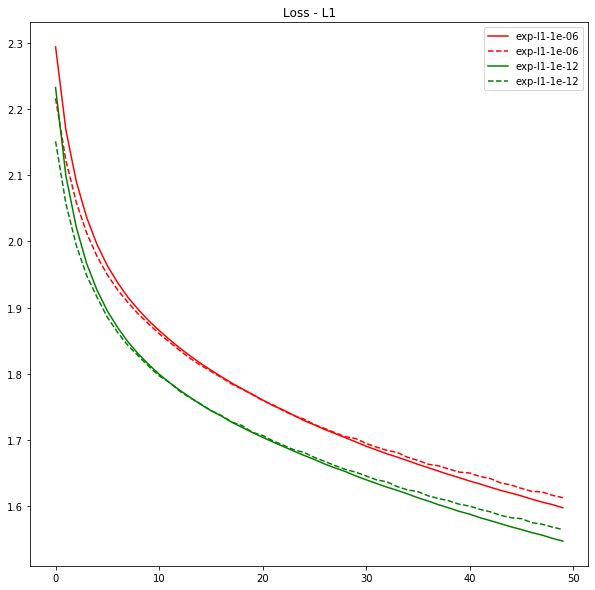

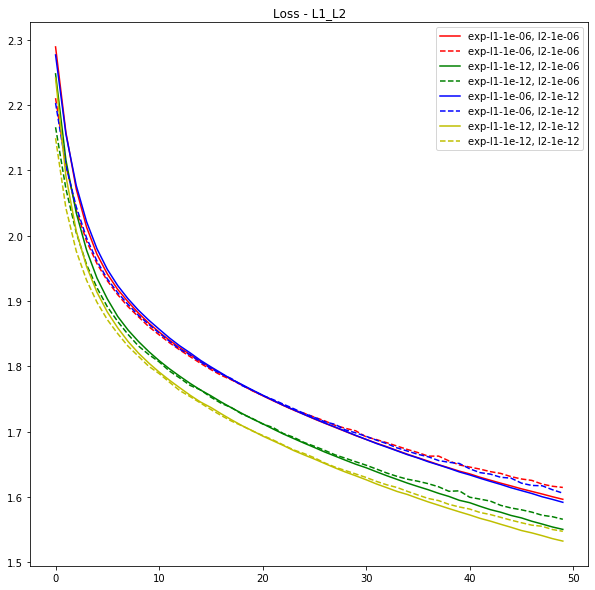

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "goldenrod", "c", "orchid", "palevioletred", "saddlebrown", "lime"]

plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_results.keys()):
    plt.plot(range(len(L1_results[cond]['train-loss'])), L1_results[cond]['train-loss'], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_results[cond]['valid-loss'])), L1_results[cond]['valid-loss'], "--", label=cond, color=color_bar[i])
plt.title("Loss - L1")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_L2_results.keys()):
    plt.plot(range(len(L1_L2_results[cond]['train-loss'])), L1_L2_results[cond]['train-loss'], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_L2_results[cond]['valid-loss'])), L1_L2_results[cond]['valid-loss'], "--", label=cond, color=color_bar[i])
plt.title("Loss - L1_L2")
plt.legend()
plt.show()

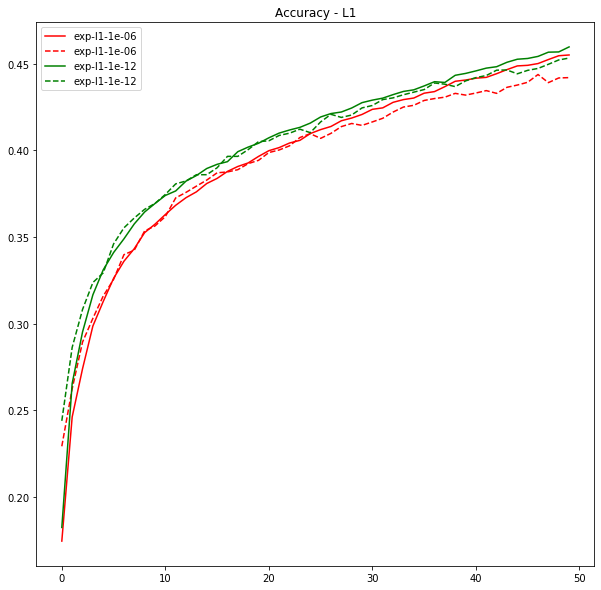

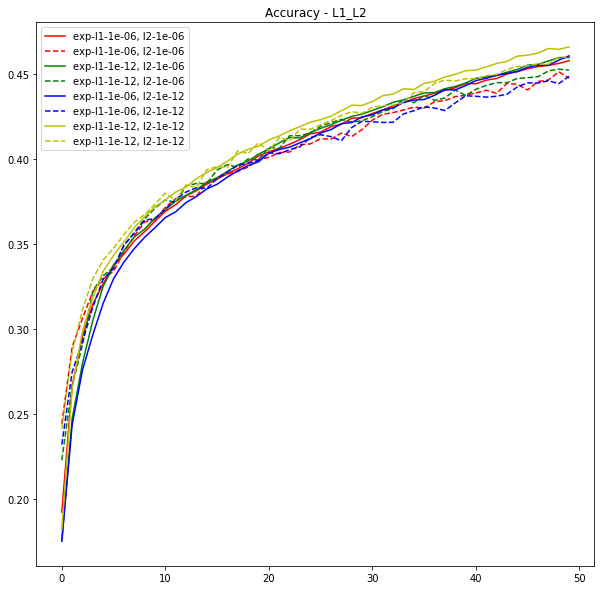

In [9]:
plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_results.keys()):
    plt.plot(range(len(L1_results[cond]["train-acc"])), L1_results[cond]["train-acc"], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_results[cond]["valid-acc"])), L1_results[cond]["valid-acc"], "--", label=cond, color=color_bar[i])
plt.title("Accuracy - L1")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(L1_L2_results.keys()):
    plt.plot(range(len(L1_L2_results[cond]["train-acc"])), L1_L2_results[cond]["train-acc"], "-", label=cond, color=color_bar[i])
    plt.plot(range(len(L1_L2_results[cond]["valid-acc"])), L1_L2_results[cond]["valid-acc"], "--", label=cond, color=color_bar[i])
plt.title("Accuracy - L1_L2")
plt.legend()
plt.show()

## 結果討論

L1及L1_L2的Accuracy差不多都落在0.45左右，都比L2 regularization accuracy 0.7來的差
